In [1]:
import xarray as xr
import os
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin/'
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.style.use('../grl.mplstyle') # Plotting style

from helper import compute_dEdt, compute_waves, compute_Phi
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 3

In [4]:
DIR = '/Users/jiarongw/Data/multilayer_data/JPO2024/processed/'
labels = ['C1','C2','C3','C4_rand4','C4','C5_rand4']
tbins = [100, 120, 140, 160, 180]
tcs = [110, 130, 150, 170]

N = 2**10
L0 = 200

### Energy against fifth moment

In [36]:
def fifth_moment(hist, tbins, N=10, L0=200, FILTER=True):
    hist['hist_norm'] = hist.hist/2**N/L0/(hist.c[2] - hist.c[1])
    hist['fifth'] = hist.hist_norm * hist.c**5
    grouped = hist.groupby_bins('t', bins=tbins).mean()
    if FILTER:
        cond = (grouped.hist_norm.max(dim='t_bins') - grouped.hist_norm.min(dim='t_bins'))/ grouped.hist_norm.mean(dim='t_bins') < 2
        integral = grouped.fifth.where(cond).sum(dim='c').values
    else:
        integral = grouped.fifth.sum(dim='c').values
    return integral

In [37]:
file = '/Users/jiarongw/Data/multilayer_data/JPO2024/processed/C5/breaking_hist.nc'
hist = xr.open_dataset(file, engine='h5netcdf')
tbins = [100, 120, 140, 160, 180]
integral = fifth_moment(hist, tbins, FILTER=True)
print(integral)
integral = fifth_moment(hist, tbins, FILTER=False)
print(integral)

[1.84340797 1.6565795  2.96171547 2.59533161]
[2.09013284 1.72322142 5.91584373 3.03269759]


In [39]:
#### Collect all samples over different cases and time windows ###3
def compute_cases (labels, FILTER=False):
    sigma_all = []
    fifth_all  = []
    dEdt_all = []

    for label in labels:
        print(label)
        filename = DIR + label + '/series.nc'
        ds = xr.open_dataset(filename, engine='h5netcdf')
        filename = DIR + label + '/breaking_hist.nc'
        hist = xr.open_dataset(filename, engine='h5netcdf')
        
        dEdts = compute_dEdt(ds, tbins) # Compute dE/dt 
        sigmas, Hss = compute_waves(ds, tbins) # Compute sigma and Hs
        fifth_ensem = fifth_moment(hist, tbins, FILTER=FILTER) # Compute fifth moment
        sigma_all.append(sigmas); fifth_all.append(fifth_ensem); dEdt_all.append(dEdts)
        
    fifth_all = np.array(fifth_all).flatten()
    dEdt_all = - np.array(dEdt_all).flatten()
    sigma_all = np.array(sigma_all).flatten()
        
    Phi_ensem = compute_Phi(labels, tcs, DIR)
    Phi_all = np.array([Phi['phis'] for Phi in Phi_ensem]).flatten()
    return sigma_all, fifth_all, dEdt_all, Phi_all

sigma_all, fifth_all, dEdt_all, Phi_all = compute_cases(['C1','C2','C3','C4_rand4','C4','C5_rand4','C5'], FILTER=True)
sigma_all2, fifth_all2, dEdt_all2, Phi_all2 = compute_cases(['C4','C4_NL30','C4_NL45'], FILTER=True)


C1
C2
C3
C4_rand4
C4
C5_rand4
C5
C4
C4_NL30
C4_NL45


### Energy against fifth moment

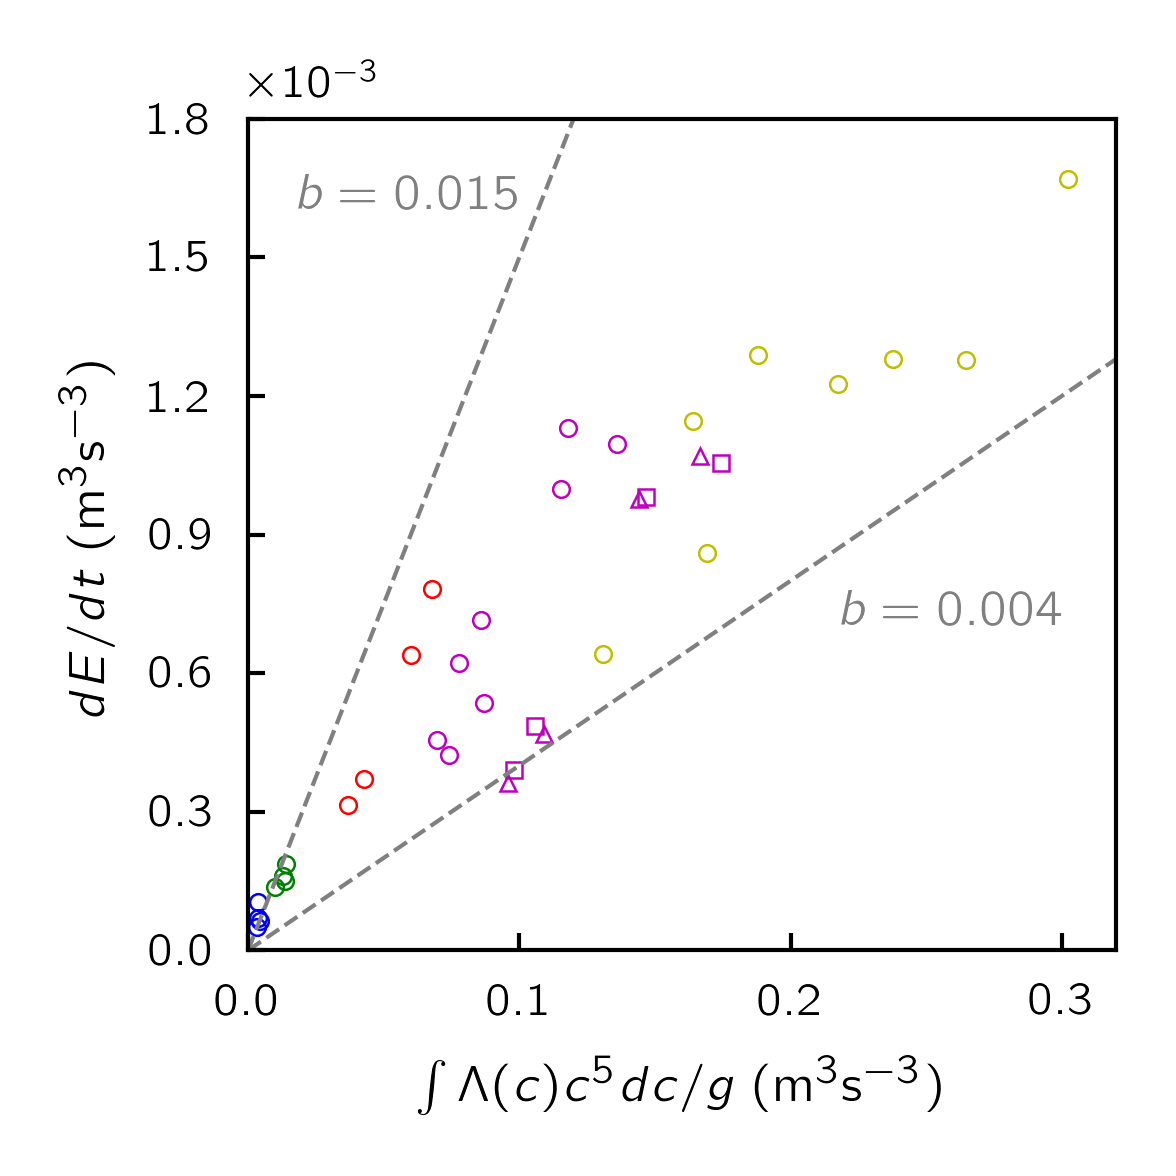

In [87]:
fig = plt.figure(figsize=[2,2]); ax = plt.gca()


colors = ['C0','C1','C2','C4','C5']
g = 9.8

for i in range(0,4):
    ax.plot(fifth_all[i]/9.8, dEdt_all[i], 'o', c=colors[0])
for i in range(4,8):
    ax.plot(fifth_all[i]/9.8, dEdt_all[i], 'o', c=colors[1])
for i in range(8,12):
    ax.plot(fifth_all[i]/9.8, dEdt_all[i], 'o', c=colors[2])
for i in range(12,20):
    ax.plot(fifth_all[i]/9.8, dEdt_all[i], 'o', c=colors[3])
for i in range(4,8):
    ax.plot(fifth_all2[i]/9.8, dEdt_all2[i], 's', c=colors[3])
for i in range(8,12):
    ax.plot(fifth_all2[i]/9.8, dEdt_all2[i], '^', c=colors[3])
for i in range(20,24):
    ax.plot(fifth_all[i]/9.8, dEdt_all[i], 'o', c=colors[4])
for i in range(24,28):
    ax.plot(fifth_all[i]/9.8, dEdt_all[i], 'o', c=colors[4])

# for i in range(0,len(Phi_all)):
#     ax.plot(fifth_all[i], dEdt_all[i], 'o', c=mpl.colormaps['Oranges']((sigma_all[i]-0.05)/(0.185-0.05)))

ax.set_xlim([0,0.32])    
ax.set_ylim([0,0.0018])   
ax.set_yticks([0,0.0003, 0.0006, 0.0009, 0.0012, 0.0015, 0.0018])    
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

ax.set_xlabel(r'$\int \Lambda(c)c^5 dc / g \;\mathrm{(m^3s^{-3})}$', fontsize=6)
ax.set_ylabel(r'$dE/dt \;\mathrm{(m^3s^{-3})}$',fontsize=6)

x = np.arange(0,0.4,0.01)
ax.plot(x, x*0.015, '--', c='gray')
ax.plot(x, x*0.004, '--', c='gray')
ax.annotate("$b=0.015$", xy=(0.06, 1.6*10**(-3)), xycoords='data',
            color='gray', ha="center", fontsize=6)
ax.annotate("$b=0.004$", xy=(0.26, 0.7*10**(-3)), xycoords='data',
            color='gray', ha="center", fontsize=6)

from matplotlib.ticker import ScalarFormatter, NullLocator
ax.xaxis.set_minor_locator(NullLocator())
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.xaxis.get_major_formatter().set_scientific(False)


plt.tight_layout()
fig.savefig('plots/dEdt_fifth.pdf', bbox_inches='tight')


In [ ]:
fig = plt.figure(figsize=[1.6,1.6]); ax = plt.gca()


for i in range(0,4):
    ax.plot(fifth_all2[i], dEdt_all2[i], 'o', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))
for i in range(4,8):
    ax.plot(fifth_all2[i], dEdt_all2[i], 'x', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))
for i in range(8,12):
    ax.plot(fifth_all2[i], dEdt_all2[i], 's', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))

for i in range(0,len(Phi_all)):
    ax.plot(fifth_all[i], dEdt_all[i], 'o', c=mpl.colormaps['Oranges']((sigma_all[i]-0.05)/(0.185-0.05)))

plt.xlim([0,4])    
plt.ylim([0,0.0014])       
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

ax.set_xlabel(r'$\int \Lambda(c)c^5 dc$', fontsize=6)
ax.set_ylabel('$\epsilon=dE/dt$',fontsize=6)

plt.tight_layout()


In [64]:
# fig = plt.figure(figsize=[1.8,1.8]); ax = plt.gca()

# # Fit a line that intercepts (0,0)

# def func(x, a):
#     return a * x

# popt, pcov = curve_fit(func, fifth_all, dEdt_all)
# print('Linear fit through (0,0) slope is %g' %popt)

# for i in range(len(fifth_all)):
#     ax.plot(fifth_all[i]*popt, dEdt_all[i], 'o', c=mpl.colormaps['Oranges']((sigma_all[i]-0.05)/(0.2-0.05)))

# ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
# ax.set_xlabel('$b_\mathrm{fit}\sum \Lambda(c)c^5/g$'); ax.set_ylabel('$\epsilon=dE/dt$')
# ax.text(0.5,0.9,'$b_\mathrm{fit}=%.4f$' %popt, transform=ax.transAxes, fontsize=6)
# ax.plot(np.linspace(0,1.2*10**(-3),100), np.linspace(0,1.2*10**(-3),100), '--', c='gray', alpha=0.5)
# ax.set_xlim([0,1.25*10**(-3)]); ax.set_ylim([0,1.25*10**(-3)])
# ax.set_yticks([0,0.25*10**(-3),0.5*10**(-3),0.75*10**(-3),1*10**(-3),1.25*10**(-3)])
# plt.show()

### Energy against Phi

In [ ]:
''' Energy against Phi, Phi is computed by fig3.ipynb and stored in datalocal '''
    
fig = plt.figure(figsize=[1.6,1.6]); ax = plt.gca()

def func(x, a, b):
    return a * x + b
popt, pcov = curve_fit(func, Phi_all, dEdt_all)

for i in range(len(Phi_all)):
    ax.plot(Phi_all[i]*popt[0]+popt[1], dEdt_all[i], 'o', c=mpl.colormaps['Oranges']((sigma_all[i]-0.05)/(0.2-0.05)))          

ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax.set_xlim([0,0.0012]); ax.set_ylim([0,0.0012])
ax.set_xlabel(r'$\nu_\mathrm{fit}\int |\mathbf{\Omega}|^2 dz$', fontsize=6)
ax.set_ylabel('$\epsilon=dE/dt$',fontsize=6)
ax.text(0.5,0.9,r'$\nu_\mathrm{fit}=%.4f$' %nufit, transform=ax.transAxes, fontsize=6)
ax.plot(np.linspace(0,1.2*10**(-3),100), np.linspace(0,1.2*10**(-3),100), '--', c='gray', alpha=0.5)
# plt.savefig('../figures/multilayer-diss/fig5b.pdf', bbox_inches='tight')

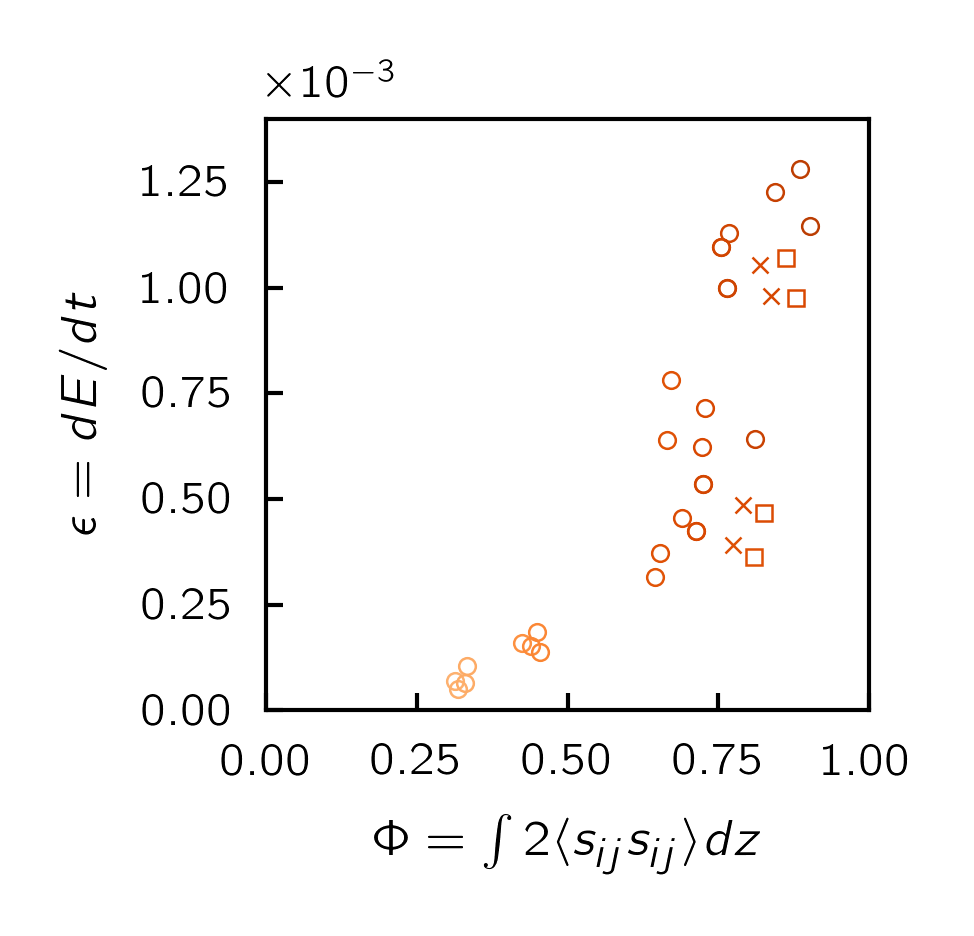

In [65]:
fig = plt.figure(figsize=[1.6,1.6]); ax = plt.gca()
for i in range(0,4):
    ax.plot(Phi_all2[i], dEdt_all2[i], 'o', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))
for i in range(4,8):
    ax.plot(Phi_all2[i], dEdt_all2[i], 'x', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))
for i in range(8,12):
    ax.plot(Phi_all2[i], dEdt_all2[i], 's', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))

for i in range(0,len(Phi_all)):
    ax.plot(Phi_all[i], dEdt_all[i], 'o', c=mpl.colormaps['Oranges']((sigma_all[i]-0.05)/(0.185-0.05)))

plt.xlim([0,1])    
plt.ylim([0,0.0014])       
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

ax.set_xlabel(r'$\Phi = \int 2 \langle s_{ij}s_{ij} \rangle dz $', fontsize=6)
ax.set_ylabel('$\epsilon=dE/dt$',fontsize=6)

plt.tight_layout()


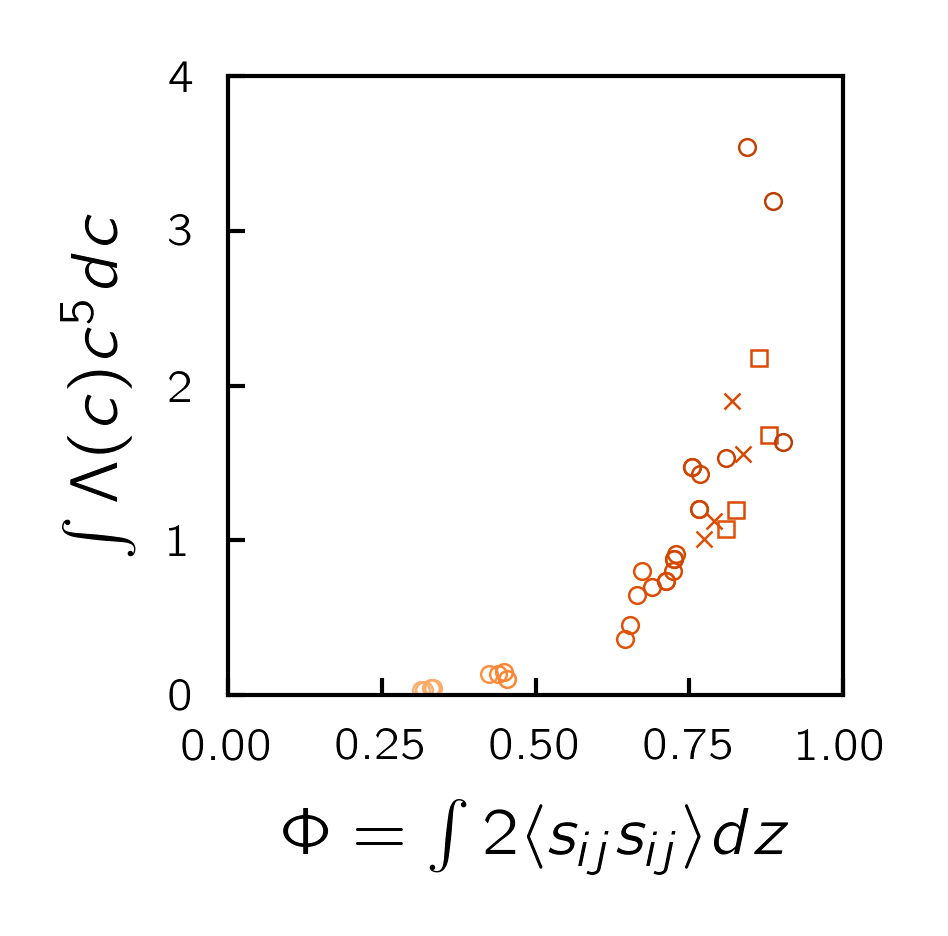

In [67]:
fig = plt.figure(figsize=[1.6,1.6]); ax = plt.gca()

# Fit a line that intercepts (0,0)
for i in range(0,4):
    ax.plot(Phi_all2[i], fifth_all2[i], 'o', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))
for i in range(4,8):
    ax.plot(Phi_all2[i], fifth_all2[i], 'x', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))
for i in range(8,12):
    ax.plot(Phi_all2[i], fifth_all2[i], 's', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))

for i in range(0,len(Phi_all)):
    ax.plot(Phi_all[i], fifth_all[i], 'o', c=mpl.colormaps['Oranges']((sigma_all[i]-0.05)/(0.185-0.05)))

ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax.set_xlabel(r'$\Phi = \int2 \langle s_{ij}s_{ij} \rangle dz $'); ax.set_ylabel(r'$\int \Lambda(c)c^5 dc$')
# ax.text(0.5,0.9,'$b_\mathrm{fit}=%.4f$' %popt, transform=ax.transAxes, fontsize=6)
# ax.plot(np.linspace(0,1.2*10**(-3),100), np.linspace(0,1.2*10**(-3),100), '--', c='gray', alpha=0.5)
# ax.set_xlim([0,1.25*10**(-3)]); ax.set_ylim([0,1.25*10**(-3)])
# ax.set_yticks([0, 0.25*10**(-3), 0.5*10**(-3), 0.75*10**(-3), 1*10**(-3), 1.25*10**(-3)])

plt.xlim([0,1]) 
plt.ylim([0,4]) 
plt.tight_layout()

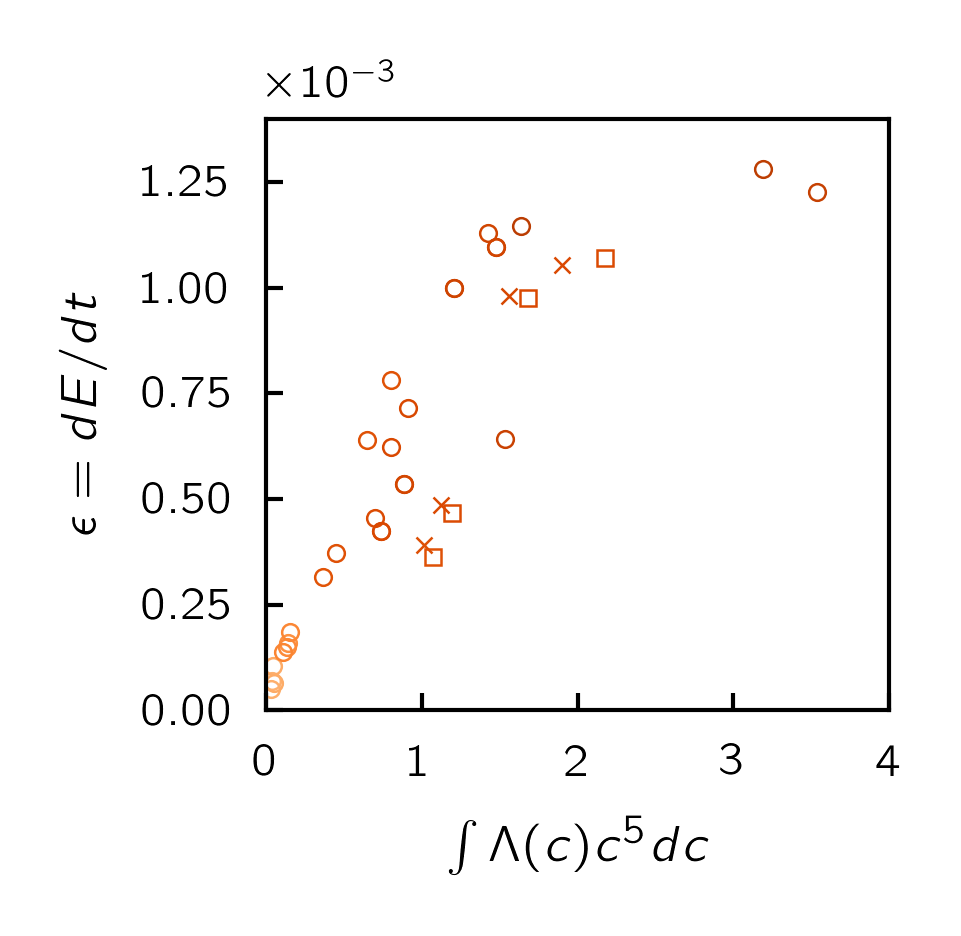

In [68]:
fig = plt.figure(figsize=[1.6,1.6]); ax = plt.gca()
for i in range(0,4):
    ax.plot(fifth_all2[i], dEdt_all2[i], 'o', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))
for i in range(4,8):
    ax.plot(fifth_all2[i], dEdt_all2[i], 'x', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))
for i in range(8,12):
    ax.plot(fifth_all2[i], dEdt_all2[i], 's', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))

for i in range(0,len(Phi_all)):
    ax.plot(fifth_all[i], dEdt_all[i], 'o', c=mpl.colormaps['Oranges']((sigma_all[i]-0.05)/(0.185-0.05)))

plt.xlim([0,4])    
plt.ylim([0,0.0014])       
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

ax.set_xlabel(r'$\int \Lambda(c)c^5 dc$', fontsize=6)
ax.set_ylabel('$\epsilon=dE/dt$',fontsize=6)

plt.tight_layout()


In [ ]:
''' Different resolution '''
fig = plt.figure(figsize=[1.8,1.8]); ax = plt.gca()

# Fit a line that intercepts (0,0)
for i in range(0,4):
    ax.plot(fifth_all2[i]/9.8, dEdt_all2[i], 'o', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))
for i in range(4,8):
    ax.plot(fifth_all2[i]/9.8, dEdt_all2[i], 'x', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))
for i in range(8,12):
    ax.plot(fifth_all2[i]/9.8, dEdt_all2[i], 's', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))


ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax.set_xlabel('$\sum \Lambda(c)c^5/g$'); ax.set_ylabel('$\epsilon=dE/dt$')
# ax.text(0.5,0.9,'$b_\mathrm{fit}=%.4f$' %popt, transform=ax.transAxes, fontsize=6)
# ax.plot(np.linspace(0,1.2*10**(-3),100), np.linspace(0,1.2*10**(-3),100), '--', c='gray', alpha=0.5)
# ax.set_xlim([0,1.25*10**(-3)]); ax.set_ylim([0,1.25*10**(-3)])
ax.set_yticks([0, 0.25*10**(-3), 0.5*10**(-3), 0.75*10**(-3), 1*10**(-3), 1.25*10**(-3), 1.5*10**(-3), 1.75*10**(-3), 2*10**(-3)])
plt.show()

fig = plt.figure(figsize=[1.8,1.8]); ax = plt.gca()

# Fit a line that intercepts (0,0)
for i in range(0,4):
    ax.plot(Phi_all2[i], dEdt_all2[i], 'o', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))
for i in range(4,8):
    ax.plot(Phi_all2[i], dEdt_all2[i], 'x', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))
for i in range(8,12):
    ax.plot(Phi_all2[i], dEdt_all2[i], 's', c=mpl.colormaps['Oranges']((sigma_all2[i]-0.05)/(0.185-0.05)))


ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax.set_xlabel('$\sum \Lambda(c)c^5/g$'); ax.set_ylabel('$\epsilon=dE/dt$')
# ax.text(0.5,0.9,'$b_\mathrm{fit}=%.4f$' %popt, transform=ax.transAxes, fontsize=6)
# ax.plot(np.linspace(0,1.2*10**(-3),100), np.linspace(0,1.2*10**(-3),100), '--', c='gray', alpha=0.5)
# ax.set_xlim([0,1.25*10**(-3)]); ax.set_ylim([0,1.25*10**(-3)])
ax.set_yticks([0, 0.25*10**(-3), 0.5*10**(-3), 0.75*10**(-3), 1*10**(-3), 1.25*10**(-3)])
plt.show()

In [35]:
def stat_std (hist, LEVEL=10, L=200):
    hist_aver_mean = hist.hist.mean(dim='t')
    hist_aver_std = hist.hist.std(dim='t')
    l = hist_aver_mean/2**LEVEL/L/(hist.c[2] - hist.c[1])
    l_std = hist_aver_std/2**LEVEL/L/(hist.c[2] - hist.c[1])
    lambdac = l.where(l_std/l < 1, drop=True)
    lambdac_std = l_std.where(l_std/l < 1, drop=True)
    c = hist.c.where(l_std/l < 1, drop=True)
    upper = (lambdac+lambdac_std).values*c.values**5
    lower = (lambdac-lambdac_std).values*c.values**5
    mid = (lambdac).values*c.values**5
    return mid.sum(), upper.sum(), lower.sum()

def stat_std_nofilter (hist, LEVEL=10, L=200):
    l = hist.hist/2**LEVEL/L/(hist.c[2] - hist.c[1])
    fifth = (l.where(hist.c<5)*hist.c.where(hist.c<5)**5).sum(dim='c')
    fifth_mean = fifth.mean(dim='t').values
    fifth_std = fifth.std(dim='t').values
    return fifth_mean, fifth_mean + fifth_std, fifth_mean - fifth_std

DIR = '/Users/jiarongw/Data/multilayer_data/JPO2024/processed/'
labels = ['C1','C2','C3','C4_rand4','C4','C5_rand4']

mids = []; uppers = []; lowers = []
mids_ = []; uppers_ = []; lowers_ = []
for label in labels:
    filename = DIR + label + '/breaking_hist.nc'
    hist = xr.open_dataset(filename, engine='h5netcdf')
    mid, upper, lower = stat_std(hist)
    mids.append(mid); uppers.append(upper); lowers.append(lower)
    mid, upper, lower = stat_std_nofilter(hist)
    mids_.append(mid); uppers_.append(upper); lowers_.append(lower)
    
mids = np.array(mids); uppers = np.array(uppers); lowers = np.array(lowers)
mids_ = np.array(mids_); uppers_ = np.array(uppers_); lowers_ = np.array(lowers_)


In [24]:
dEdt_all = []
tbins = [100, 180]

for label in labels:
    print(label)
    filename = DIR + label + '/series.nc'
    ds = xr.open_dataset(filename, engine='h5netcdf')
    dEdts = compute_dEdt(ds, tbins) # Compute dE/dt 
    dEdt_all.append(dEdts)
    
dEdt_all = - np.array(dEdt_all).flatten()

C1
C2
C3
C4_rand4
C4
C5_rand4


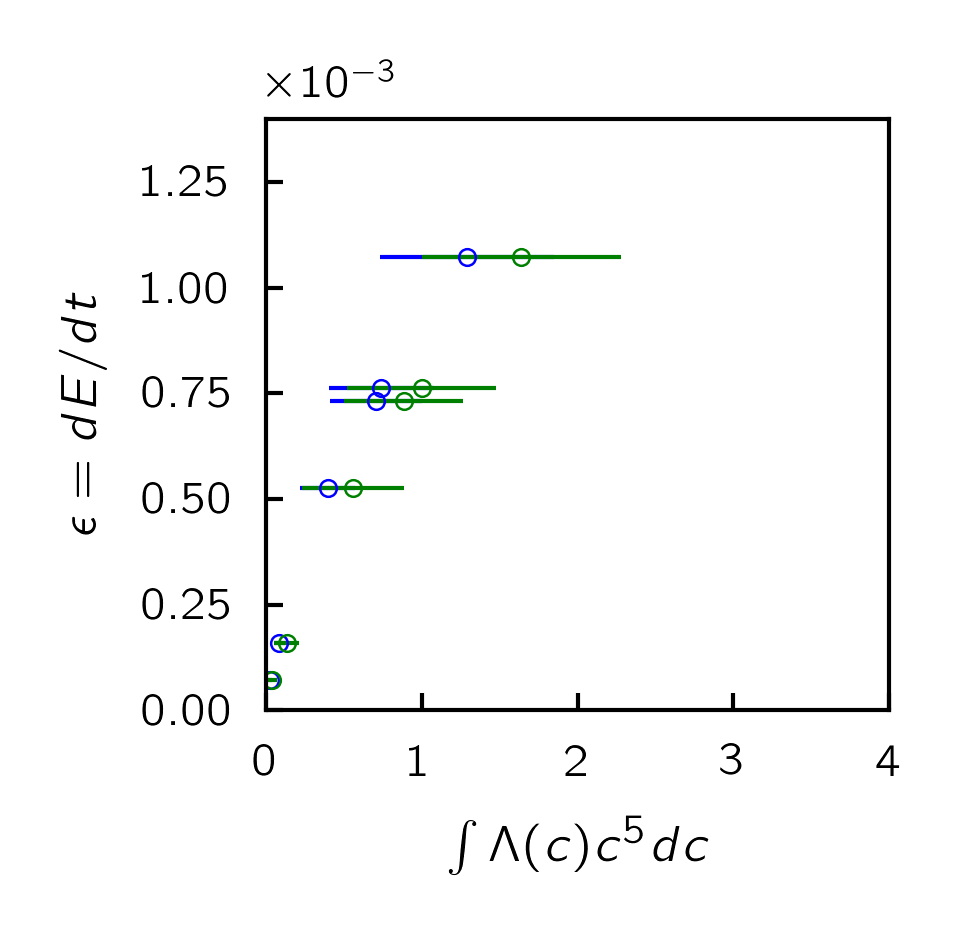

In [36]:
fig = plt.figure(figsize=[1.6,1.6]); ax = plt.gca()

# ax.plot(fifth_all, dEdt_all, 'o', c=mpl.colormaps['Oranges']((sigma_all[i]-0.05)/(0.185-0.05)))
ax.errorbar(mids, dEdt_all, xerr=(mids-lowers, uppers-mids), fmt='o')
ax.errorbar(mids_, dEdt_all, xerr=(mids_-lowers_, uppers_-mids_), fmt='o')

  
plt.xlim([0,4])    
plt.ylim([0,0.0014])       
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

ax.set_xlabel(r'$\int \Lambda(c)c^5 dc$', fontsize=6)
ax.set_ylabel('$\epsilon=dE/dt$',fontsize=6)

plt.tight_layout()


In [27]:
print(mids)
print(uppers)
print(lowers)

[0.0233506  0.08504656 0.39348858 0.70579851 0.74000196 1.29258282]
[0.03627446 0.12081161 0.56797992 1.00339637 1.07665023 1.85178021]
[0.01042674 0.04928151 0.21899724 0.40820065 0.40335369 0.73338544]
